In [1]:
import os
import pandas as pd
import numpy as np

np.random.seed(seed=42)

### 데이터 전처리

In [2]:
data_dir = "../data"
preprocessed_output_dir = "../data/implicit/train"
df_ratebeer = pd.read_csv(os.path.join(data_dir,"preprocessed_ratebeer.tsv"), sep = "\t")
del df_ratebeer["Unnamed: 0"]

In [3]:
total_med = df_ratebeer["review_score"].describe()["50%"]
print("total_med :", round(total_med,3))

total_med : 3.5


In [6]:
df_rating = df_ratebeer[["user_id", "beer_id", "review_score", "review_time"]].copy()

In [34]:
df_rating[df_rating["user_id"] == 5540]["review_score"].median()

4.0

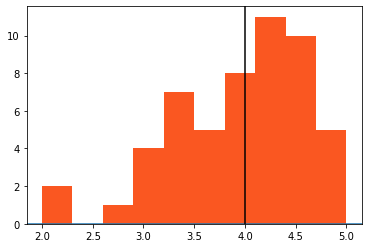

In [38]:
import matplotlib
import matplotlib.pyplot as plt

df_rating[df_rating["user_id"] == 5540]["review_score"].hist(bins=10, color="#FA5721")
med = df_rating[df_rating["user_id"] == 5540]["review_score"].median()
plt.grid(False)
plt.axhline()
plt.axvline(x=med, color="black")


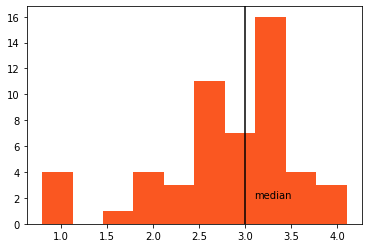

In [53]:
df_rating[df_rating["user_id"] == 11855]["review_score"].hist(bins=10, color="#FA5721")
med = df_rating[df_rating["user_id"] == 11855]["review_score"].median()
plt.grid(False)
plt.text(x= med+0.1, y=2 , s="median")
plt.axvline(x=med, color="black")

Text(4.1, 2, 'median')

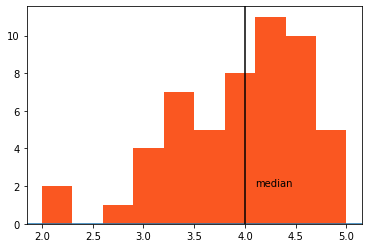

In [69]:
df_rating[df_rating["user_id"] == 5540]["review_score"].hist(bins=10, color="#FA5721")
med = df_rating[df_rating["user_id"] == 5540]["review_score"].median()
plt.grid(False)
plt.axhline()
plt.axvline(x=med, color="black")
plt.text(x= med+0.1, y=2 , s="median")

In [71]:
med = df_rating[df_rating["user_id"] == 5540]["review_score"].median()
pos = sum(df_rating[df_rating["user_id"] == 5540]["review_score"] >= med)
neg = sum(df_rating[df_rating["user_id"] == 5540]["review_score"] < med)
print(pos, neg)

31 22


<BarContainer object of 2 artists>

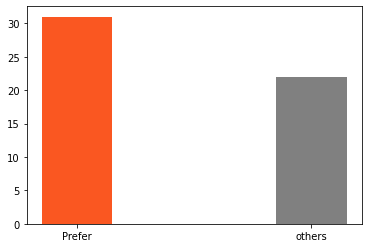

In [72]:
plt.bar(x = ["Prefer", "others"], height=[31, 22],width=0.3, color = ["#FA5721", "grey"])

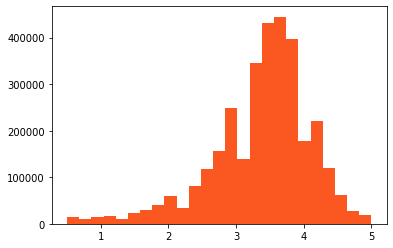

In [51]:
df_rating.review_score.hist(bins=25, color="#FA5721")
plt.yticks
plt.grid(False)

In [13]:
df_rating.value_counts("user_id")[df_rating.value_counts("user_id")==53]

user_id
13607    53
504      53
25821    53
11855    53
7771     53
         ..
7485     53
5728     53
11279    53
17657    53
5540     53
Length: 66, dtype: int64

In [5]:
# 리뷰 개수 3개 이하인 유저 삭제
target_user = (df_rating.value_counts("user_id") <= 3).where(lambda x: x == True).dropna().index.tolist()
df_rating = df_rating[~df_rating["user_id"].isin(target_user)].sort_values(["user_id", "review_time"])
df_rating.index = range(len(df_rating))
df_rating.tail(2)

,user_id,beer_id,review_score,review_time
3190759,56904,7344,2.6,2012-07-07 23:15:19.813000+00:00
3190760,56904,115220,2.7,2012-07-09 20:14:10.970000+00:00


In [78]:
df_rating["prefrence"] = df_rating.groupby("user_id")["review_score"].transform(lambda x: x >= np.median(x))

In [79]:
df_train_ratings = df_rating.query("prefrence==True")[["user_id", "beer_id", "review_time"]]
df_train_ratings.columns = ["user", "item", "time"]
df_train_ratings.index = range(len(df_train_ratings))
df_train_ratings

,user,item,time
0,0,94349,2012-04-21 12:52:53.937000+00:00
1,0,113934,2012-04-23 11:10:32.493000+00:00
2,0,116128,2012-04-26 14:04:58.673000+00:00
3,0,13324,2012-04-28 12:36:33.710000+00:00
4,0,59023,2012-04-30 14:50:31.823000+00:00
...,...,...,...
1724176,55119,137463,2012-10-02 07:09:40.127000+00:00
1724177,55119,11206,2012-10-22 06:47:25.057000+00:00
1724178,56904,50036,2012-07-06 09:30:52.073000+00:00
1724179,56904,35164,2012-07-07 21:58:27.007000+00:00


In [92]:
# to timestamp
import time
import datetime

df_train_ratings["time"] = df_train_ratings["time"].apply(lambda x: x.replace("T", " "))
df_train_ratings["time"] = df_train_ratings["time"].apply(lambda x: time.mktime(datetime.datetime.strptime(x[:18], "%Y-%m-%d %H:%M:%S").timetuple()))

In [93]:
n_item = df_train_ratings.item.nunique()
n_user = df_train_ratings.user.nunique()
n_data = len(df_train_ratings)

print(f"n item: {n_item:,}")
print(f"n user: {n_user:,}")
print(f"n data: {n_data:,}")
print(f"sparsity: {1-n_data/n_item/n_user:%}")

n item: 9,274
n user: 23,848
n data: 1,724,181
sparsity: 99.220414%


In [94]:
# target beer list
df_target_beer = pd.read_csv("/opt/ml/workspace/final-project-level3-recsys-10/data/db_files/db_target_beer.csv")
target_beer_set = set(df_target_beer["beer_id"])

In [95]:
n_target_beers = len(set(df_train_ratings.item).intersection(target_beer_set))
print("n_target_beers :", n_target_beers)

n_target_beers : 73


In [96]:
# train_test_split
np.random.seed(42)

ratio = 0.08
n_test_user = int(ratio*n_user)

test_user = np.random.choice(df_train_ratings["user"].unique(), size=n_test_user, replace=False)

In [98]:
df_test = df_train_ratings[df_train_ratings["user"].isin(test_user)]
df_train = df_train_ratings[~df_train_ratings["user"].isin(test_user)]

In [103]:
import tqdm
np.random.seed(42)
ratio = 0.1
n_test_user = int(ratio*n_user)

# for i in tqdm.tqdm(range(10000)):
test_user = np.random.choice(df_train_ratings["user"].unique(), size=n_test_user, replace=False)
df_test = df_train_ratings[df_train_ratings["user"].isin(test_user)]
df_train = df_train_ratings[~df_train_ratings["user"].isin(test_user)]
go_to_train_item = set(df_test.item.unique()) - set(df_train.item.unique())
print(go_to_train_item)


{10976, 12261, 10726, 37863, 146725, 124391, 49802, 18606, 24818, 102643, 6168, 115546, 10877, 83231}


In [110]:
go_to_train_user = df_test[df_test["item"].isin(go_to_train_item)]["user"].tolist()
df_train = pd.concat([df_train, df_test[df_test["user"].isin(go_to_train_user)]], axis=0)
df_test = df_test[~df_test["user"].isin(go_to_train_user)]

df_train.index = range(len(df_train))
df_test.index = range(len(df_test))

In [111]:
print(df_test.item.nunique())
print(df_train.item.nunique())

print(len(set(df_test.item.unique()) - set(df_train.item.unique())))

8347
9274
0


In [112]:
df_train.to_csv("train_ratings.csv", index = False)
df_test.to_csv("test_file.csv", index = False)